In [1]:
import matplotlib
# Force matplotlib to not use any Xwindows backend.
# matplotlib.use('Agg')
from matplotlib import pyplot as plt
from keras.models import Sequential, model_from_json, load_model
from keras.layers.core import Dense, Dropout, Flatten, Activation, SpatialDropout2D, Reshape, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU, PReLU, LeakyReLU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import Convolution1D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from scipy.io import wavfile
import pdb
import scipy.io
import librosa
import os
from os.path import join as ojoin
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
from keras.layers import CuDNNGRU, CuDNNLSTM
import time  
import numpy as np
import numpy.matlib
import argparse
import random
import theano
# os.environ['KERAS_BACKEND'] = 'theano'
# import theano.tensor as T
import tensorflow as tf
from keras.callbacks import TensorBoard
import keras.backend.tensorflow_backend as KTF
# from keras.utils import to_categorical,plot_model
from ipykernel import kernelapp as app
from tensorflow.keras import regularizers
tf.reset_default_graph()


Using TensorFlow backend.
C:\Users\hsiaoen\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hsiaoen\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hsiaoen\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hsiaoen\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Future

In [2]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
KTF.set_session(session)
random.seed(999)

GPU found


In [3]:
def get_filepaths(directory):
    """
    This function will generate the file names in a directory 
    tree by walking the tree either top-down or bottom-up. For each 
    directory in the tree rooted at directory top (including top itself), 
    it yields a 3-tuple (dirpath, dirnames, filenames).
    """
    file_paths = []  # List which will store all of the full filepaths.

    # Walk the tree.

    for root, directories, files in os.walk(directory):

        for filename in files:
            if filename.endswith('.wav'):
            # Join the two strings in order to form the full filepath.
                filepath = os.path.join(root, filename)
                file_paths.append(filepath)  # Add it to the list.
                # pdb.set_trace()

    return file_paths  # Self-explanatory.
mixed_file=get_filepaths('mixed_all_snr')
cleaned_file=get_filepaths('clean')


In [4]:
#整理檔案路徑排序
#確認乾淨的答案有對應到混音完的檔案
clean_files=[]
for i in mixed_file:
    clean_file='_'.join(i.split('\\')[1].split('_')[:3])+'.wav'
    for j in cleaned_file:
#         print(j)
        if clean_file == j.split('\\')[-1]:
            clean_files.append(j)
        

In [5]:
clean_files[:10]

['clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav',
 'clean\\amanda\\amanda_T01-10_20200626.wav']

In [8]:
##切分train-test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mixed_file,clean_files,test_size=0.33, random_state=42)    
Train_Noisy_lists=X_train
Train_Clean_paths= y_train

Test_Noisy_lists  = X_test
Test_Clean_paths = y_test
          
Num_testdata=len(Test_Noisy_lists)   
Num_traindata=len(Train_Noisy_lists)

In [9]:
def train_data_generator(noisy_list, clean_path):
    index=0
    while True:
        noisy, rate  = librosa.load(noisy_list[index],sr=16000) 
        # print(noisy_list[index],index)
        # pdb.set_trace()

        D=librosa.stft(noisy,n_fft=512,hop_length=256,win_length=512,center=False)
        noisy = np.abs(D)
        #轉向因為高固定 但長度不同
        noisy = noisy.T
        noisy=np.reshape(noisy,(1,np.shape(noisy)[0],np.shape(noisy)[1]))
        noisy_shi=np.angle(D)


        clean, rate  =librosa.load(clean_path[index],sr=16000) 
        D=librosa.stft(clean,n_fft=512,hop_length=256,win_length=512,center=False)
        clean = np.abs(D)
        #轉向因為高固定 但長度不同
        clean = clean.T
        clean=np.reshape(clean,(1,np.shape(clean)[0],np.shape(clean)[1]))
        clean_shi=np.angle(D)

        index += 1
        if index == len(noisy_list):
            index = 0

        yield noisy, clean

def val_data_generator(noisy_list, clean_path):
    index=0
    while True:
        noisy, rate  = librosa.load(noisy_list[index],sr=16000)       
        D=librosa.stft(noisy,n_fft=512,hop_length=256,win_length=512,center=False)
        noisy = np.abs(D)
        #轉向因為高固定 但長度不同
        noisy = noisy.T
        noisy=np.reshape(noisy,(1,np.shape(noisy)[0],np.shape(noisy)[1]))
        noisy_shi=np.angle(D)
          
        clean, rate  =librosa.load(clean_path[index],sr=16000) 
        D=librosa.stft(clean,n_fft=512,hop_length=256,win_length=512,center=False)
        clean = np.abs(D)
        #轉向因為高固定 但長度不同
        clean = clean.T
        clean=np.reshape(clean,(1,np.shape(clean)[0],np.shape(clean)[1]))
        clean_shi=np.angle(D)


        index += 1
        if index == len(noisy_list):
            index = 0
          
        yield noisy, clean 

In [10]:

start_time = time.time()

print('model building...')

model = Sequential()
model.add(CuDNNGRU(80,  return_sequences=True, input_shape=(None,257)))
model.add(CuDNNGRU(80,  return_sequences=True))
model.add(CuDNNGRU(80,  return_sequences=True))

model.add(Dense(257,activation='tanh'))


model.add(LeakyReLU())



model.summary()

model building...



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, None, 80)          108480    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, None, 80)          51840     
_________________________________________________________________
dense_1 (Dense)              (None, None, 257)         20817     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, 257)         0         
Total params: 181,137
Trainable params: 181,137
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epoch=5
batch_size=1
# Adam=tf.keras.optimizers.Adam(lr=0.01)
model.compile(loss='mse', optimizer='adam')
    
with open('{}.json'.format('firsttry'),'w') as f:    # save the model
    f.write(model.to_json()) 
checkpointer = ModelCheckpoint(filepath='{}.hdf5'.format('firsttry'), verbose=1, save_best_only=True, mode='min')  

print ('training...')

g1 = train_data_generator(Train_Noisy_lists, Train_Clean_paths)
g2 = val_data_generator(Test_Noisy_lists, Test_Clean_paths)

tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
#                  batch_size=32,     # 用多大量的数据计算直方图
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)
hist=model.fit_generator(g1,
                         samples_per_epoch=Num_traindata,
                        # samples_per_epoch=50, 
                         nb_epoch=epoch, 
                         verbose=1,
                         validation_data=g2,
                         nb_val_samples=Num_testdata,
                         max_q_size=1, 
                         nb_worker=1,
                         pickle_safe=False,
                         )                          

In [ ]:
sav=model.save('mixed_pos_snr_raw_LSTMx2_5epoch.h5')
sav

In [ ]:
## 畫Loss圖

# # plotting the learning curve
TrainERR=hist.history['loss']
ValidERR=hist.history['val_loss']
print ('@%f, Minimun error:%f, at iteration: %i' % (hist.history['val_loss'][epoch-1], np.min(np.asarray(ValidERR)),np.argmin(np.asarray(ValidERR))+1))
# print 'drawing the training process...'
plt.clf()
plt.figure(4)
plt.plot(range(1,epoch+1),TrainERR,'b',label='TrainERR')
plt.plot(range(1,epoch+1),ValidERR,'r',label='ValidERR')
plt.xlim([1,epoch])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('error')
plt.grid(True)
plt.show()
plt.savefig('Learning_curve_{}.png', dpi=150)


end_time = time.time()
print ('The code for this file ran for %.2fm' % ((end_time - start_time) / 60.))


In [ ]:
tf.reset_default_graph()

In [ ]:
len(Test_Noisy_lists)

In [16]:
maxv = np.iinfo(np.int16).max 
for path in Test_Noisy_lists[:10]: # Ex: /mnt/hd-02/avse/testing/noisy/engine/1dB/1.wav
    S=path.split('\\') 
    # noise=S[-3]
    # dB=S[-2]
    wave_name=S[1]
    noisy, rate  = librosa.load(path,sr=16000) 
    noisy=noisy.astype('float32')
    # print(noisy_list[index],index)
    # pdb.set_trace()
    D=librosa.stft(noisy,n_fft=512,hop_length=256,win_length=512,center=False)
    noisy = np.abs(D)
    #轉向因為高固定 但長度不同
    noisy = noisy.T
    print(noisy.shape)
    noisy_shi=np.angle(D)

    noisy=np.reshape(noisy,(1,np.shape(noisy)[0],np.shape(noisy)[1]))
    print(noisy.shape)
#     print('reshape====>',noisy.shape)
    enhanced=np.squeeze( model.predict(noisy, batch_size=1)).T
#     print(enhanced.shape)
    Rec = np.multiply(enhanced, np.exp(1j * noisy_shi))
    enhanced=librosa.istft(Rec,hop_length=256,win_length=512,center=False)
#     enhanced=enhanced/np.max(abs(enhanced))
    enhanced=enhanced* maxv
    enhanced_2=enhanced.astype('int16')
#     enhanced=enhanced/2**15
    wavfile.write(os.path.join("c:\\test", wave_name),16000,(enhanced).astype(np.int16))

(212, 257)
(1, 212, 257)


(188, 257)
(1, 188, 257)
(164, 257)
(1, 164, 257)
(213, 257)
(1, 213, 257)
(170, 257)
(1, 170, 257)
(175, 257)
(1, 175, 257)
(233, 257)
(1, 233, 257)
(208, 257)
(1, 208, 257)
(195, 257)
(1, 195, 257)
(177, 257)
(1, 177, 257)


### 播放

In [9]:
model = tf.contrib.keras.models.load_model('D:/result/mixed_pos_snr_STFT_GRUx3_tanh_5epoch_ok/mixed_pos_snr_STFT_GRUx3_tanh_5epoch.h5')

(189, 257)


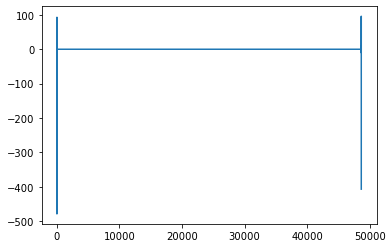

In [35]:
import IPython.display as ipd
path='C:/Users/hsiaoen/Desktop/jin_T03-8_20200620.wav'
S=path.split('/') 
wave_name=S[1]
noisy, sr = librosa.load(path,sr=16000)
noisy=noisy.astype('float32')
D=librosa.stft(noisy,n_fft=512,hop_length=256,win_length=512,center=False)
noisy = np.abs(D)
noisy = noisy.T
print(noisy.shape)
noisy_shi=np.angle(D)
noisy=np.reshape(noisy,(1,np.shape(noisy)[0],np.shape(noisy)[1]))
enhanced=np.squeeze( model.predict(noisy, batch_size=1)).T
Rec = np.multiply(enhanced, np.exp(1j * noisy_shi))
Rec[100:-100]*=100
Rec=(Rec-np.mean(Rec))//np.std(Rec)
enhanced=librosa.istft(Rec,hop_length=256,win_length=512,center=False)
enhanced_2=enhanced.astype('int16')
plt.clf()
plt.plot(enhanced_2)
ipd.Audio(enhanced_2,rate=16000) #播放
# wavfile.write(os.path.join("c:/test",wave_name),16000,(enhanced).astype(np.int16))

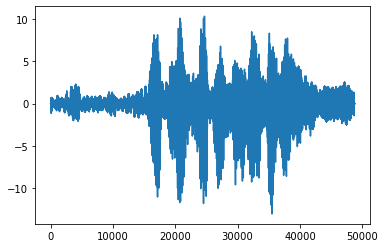

In [39]:
from pyhht.visualization import plot_imfs
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

path='C:/Users/hsiaoen/Desktop/jin_T03-8_20200620_fireengine_starting_snr4.wav'
data , sr = librosa.load(path,sr=16000) 
# data = data/abs(data).max()
data[100:-100]*=100
plt.plot(data)
ipd.Audio(data,rate=16000) #播放
librosa.output.write_wav('jin_T03-8_20200620_fireengine_starting_snr4.wav', data, sr)


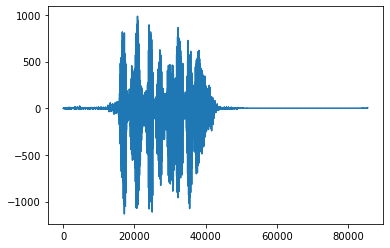

In [37]:
from pyhht.visualization import plot_imfs
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

path='C:/Users/hsiaoen/Desktop/denoise_jin_T03-8_20200620_fireengine_starting_snr4 (1).wav'
data , sr = librosa.load(path,sr=16000) 
# data = data/abs(data).max()
data[100:-100]*=100
plt.plot(data)
ipd.Audio(data,rate=16000) #播放